# Text Classification là một trong những bài toán cơ bản và quan trọng trong lĩnh vực NLP. Mục tiêu của project này là xây dựng một trương trình Text Classification liên quan đến phân loại các abstract của publication (bài báo khoa học) thành các topic khác nhau.

In [1]:
# import
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

CACHE_DIR = "./cache"

# Data Discovering & Preprocessing

In [2]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")
ds

README.md:   0%|          | 0.00/810 [00:00<?, ?B/s]

arxiv-metadata-oai-snapshot.json:   0%|          | 0.00/3.82G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2292057 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [3]:
for i in range(3):
  print(f"Example {i+1}")
  print(ds['train'][i]['abstract'])
  print(ds['train'][i]['categories'])
  print("---" * 20)

Example 1
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-ph

In [4]:
all_categories = ds['train']['categories']
print(set(all_categories))

{'hep-th gr-qc physics.acc-ph', 'math.QA math.AG math.CO', 'cs.DC physics.comp-ph quant-ph', 'cond-mat.mes-hall physics.app-ph physics.chem-ph physics.comp-ph physics.flu-dyn', 'hep-th hep-ph math.AG math.DG math.FA', 'cs.SI cs.DM math.OC', 'cs.LG cs.SD', 'physics.optics cond-mat.dis-nn cond-mat.quant-gas quant-ph', 'stat.ME math.NA math.OC math.ST stat.AP stat.TH', 'physics.soc-ph cond-mat.dis-nn cs.SI physics.data-an q-bio.NC', 'cs.LG cs.ET q-bio.BM stat.ML', 'math.OA math.FA math.RA math.RT', 'cs.LG cs.DS cs.FL', 'stat.ML eess.SP stat.CO', 'cs.IT cs.ET eess.SP math.IT', 'cs.LG cs.MA', 'math.RA math.AG math.CV math.GR', 'cs.LG cs.AI cs.IT math.IT stat.ME', 'math.CO math.NT math.SP', 'physics.app-ph cond-mat.mtrl-sci cond-mat.soft', 'physics.bio-ph nlin.AO physics.comp-ph q-bio.NC', 'cond-mat.stat-mech cond-mat.mtrl-sci cond-mat.soft physics.comp-ph', 'stat.ML cs.LG q-bio.PE q-bio.QM', 'cs.DL cs.DM cs.DS cs.SI', 'math.AP math.OC physics.flu-dyn', 'math-ph hep-th math.AP math.MP nlin.S

In [5]:
category_set = set()
for category in all_categories:
  parts = category.split(' ')
  for part in parts:
    topic = part.split('.')[0]
    category_set.add(topic)

sorted_categories = sorted(list(category_set), key=lambda x: x.lower())
print(f"There are {len(sorted_categories)} unique primary categories in the dataset:")
for category in sorted_categories:
  print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [6]:
# load 1000 samples
samples = []
CATEGORIES_TO_SELECT = ['astro-ph', 'cond-mat', 'cs', 'math', 'physics']
for s in ds['train']:
  if len(s['categories'].split(' ')) != 1:
    continue

  cur_category = s['categories'].strip().split('.')[0]
  if cur_category not in CATEGORIES_TO_SELECT:
    continue

  samples.append(s)

  if len(samples) >= 1000:
    break
print(f"Number of samples: {len(samples)}")

for sample in samples[:3]:
    print(f"Category: {sample['categories']}")
    print("Abstract:", sample['abstract'])
    print("#" * 20 + "\n")

Number of samples: 1000
Category: physics.gen-ph
Abstract:   The evolution of Earth-Moon system is described by the dark matter field
fluid model proposed in the Meeting of Division of Particle and Field 2004,
American Physical Society. The current behavior of the Earth-Moon system agrees
with this model very well and the general pattern of the evolution of the
Moon-Earth system described by this model agrees with geological and fossil
evidence. The closest distance of the Moon to Earth was about 259000 km at 4.5
billion years ago, which is far beyond the Roche's limit. The result suggests
that the tidal friction may not be the primary cause for the evolution of the
Earth-Moon system. The average dark matter field fluid constant derived from
Earth-Moon system data is 4.39 x 10^(-22) s^(-1)m^(-1). This model predicts
that the Mars's rotation is also slowing with the angular acceleration rate
about -4.38 x 10^(-22) rad s^(-2).

####################

Category: math.CO
Abstract:   We show 

# Data Preprocessing

In [7]:
preprocessed_samples = []
for s in samples:
  abstract = s['abstract']
  abstract = abstract.strip().replace("\n", " ")
  abstract = re.sub(r'[^\w\s]', '', abstract)
  abstract = re.sub(r'\d+', ' ', abstract)
  abstract = abstract.lower()

  parts = s['categories'].split(' ')
  category = parts[0].split('.')[0]

  preprocessed_samples.append({
      "text": abstract,
      "label": category
  })

for sample in preprocessed_samples[:3]:
  print(f"Label: {sample['label']}")
  print("Text:", sample['text'])
  print("#" * 20 + "\n")

Label: physics
Text: the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field   american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about   km at   billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is   x   s m  this model predicts that the marss rotation is also slowing with the angular acceleration rate about   x   rad s 
####################

Label: math
Text: we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves 

In [8]:
labels = set([s['label'] for s in preprocessed_samples])
sorted_labels = sorted(labels)
for label in sorted_labels:
  print(label)

astro-ph
cond-mat
cs
math
physics


In [9]:
label_to_id = {label: i for i, label in enumerate(sorted_labels)}
id_to_label = {i: label for i, label in enumerate(sorted_labels)}

print("Label to ID mapping")
for label, id_ in label_to_id.items():
  print(f"{label} --> {id_}")

Label to ID mapping
astro-ph --> 0
cond-mat --> 1
cs --> 2
math --> 3
physics --> 4


In [10]:
X_full = [sample['text'] for sample in preprocessed_samples]
y_full = [label_to_id[sample['label']] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42, stratify=y_full)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


# Encoder

## Bag-of-Words (BoW) là một kỹ thuật biểu diễn văn bản đơn giản và thường được sử dụng. Nó chuyển đổi văn bản thành một vector có độ dài cố định bằng cách đếm số lần xuất hiện của mỗi từ trong văn bản. Phương pháp này bỏ qua ngữ pháp và thứ tự từ nhưng vẫn giữ lại tần suất của các từ.

In [11]:
# Bag_of_Words(BoW)
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)

for i, vec in enumerate(vectors):
  print(f"Document {i+1}: {vec.toarray()}")

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


## TF-IDF (Term Frequency-Inverse Document Frequency) là một phương pháp mã hóa văn bản nâng cao hơn BoW, nó không chỉ tính tần suất của từ trong văn bản mà còn xem xét tần suất của từ trong toàn bộ tập dữ liệu. Điều này giúp giảm trọng số của các từ phổ biến và tăng trọng số của các từ hiếm gặp, từ đó cải thiện khả năng phân loại.

In [12]:
# tfidf
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vectors):
  print(f"TF_IDF for Document {i+1}:")
  print(vec.toarray())

TF_IDF for Document 1:
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF_IDF for Document 2:
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF_IDF for Document 3:
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.

## Sentence Embeddings là một phương pháp mã hóa văn bản nâng cao hơn, nó chuyển đổi toàn bộ câu hoặc đoạn văn thành một vector có kích thước cố định. Các vector này thường được huấn luyện trên các tập dữ liệu lớn và có thể nắm bắt được ngữ nghĩa của câu, từ đó cải thiện khả năng phân loại.

In [13]:
class EmbeddingVectorizer:
  def __init__(
      self,
      model_name: str = 'intfloat/multilingual-e5-base',
      normalize: bool = True
  ):
    self.model = SentenceTransformer(model_name)
    self.normalize = normalize

  def _format_inputs(
      self,
      texts: List[str],
      mode: Literal['query', 'passage']
  ) -> List[str]:
      if mode not in {"query", "passage"}:
        raise ValueError("Mode must be either 'query' or 'passage'")
      return [f"{mode}: {text.strip()}" for text in texts]

  def transform(self, texts: List[str], mode: Literal['query', 'passage'] = 'query'):
    if mode == 'raw':
      inputs = texts
    else:
      inputs = self._format_inputs(texts, mode)

    embeddings = self.model.encode(inputs, normalize_embeddings= self.normalize)
    return embeddings.tolist()

  def transform_numpy(self, texts, mode: Literal['query', 'passage'] = 'query') -> np.ndarray:
    return np.array(self.transform(texts, mode=mode))

In [14]:
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

vectorizer = EmbeddingVectorizer()
embeddings = vectorizer.transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i+1}:")
    print(emb[:10])
    print("#" * 20)

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Embedding for Document 1:
[-0.014805697835981846, 0.03127659484744072, -0.016158660873770714, 0.007545319385826588, 0.04465828835964203, -0.05123654007911682, -0.014604968018829823, -0.04828919842839241, 0.05034762993454933, 0.0047388700768351555]
####################
Embedding for Document 2:
[0.011917391791939735, 0.033273596316576004, -0.02573901042342186, 0.026533057913184166, 0.0316096656024456, -0.021373162046074867, -0.012149748392403126, -0.03784850612282753, 0.04151839017868042, 1.3289674825500697e-05]
####################
Embedding for Document 3:
[0.012662903405725956, 0.03936120867729187, -0.024181151762604713, 0.01619776152074337, 0.007417706307023764, -0.030312353745102882, -0.014685511589050293, -0.03850284218788147, 0.0069724260829389095, 0.01775604858994484]
####################
Embedding for Document 4:
[0.0063936361111700535, 0.04922199994325638, -0.028402933850884438, -0.013305905275046825, 0.0058109755627810955, -0.043715108186006546, -0.008321727626025677, -0.0413

In [15]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVectorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

# convert all to numpy arrays for consistency
X_train_bow, X_test_bow = np.array(X_train_bow.toarray()), np.array(X_test_bow.toarray())
X_train_tfidf, X_test_tfidf = np.array(X_train_tfidf.toarray()), np.array(X_test_tfidf.toarray())
X_train_embeddings, X_test_embeddings = np.array(X_train_embeddings), np.array(X_test_embeddings)

# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")

Shape of X_train_bow: (800, 10311)
Shape of X_test_bow: (200, 10311)

Shape of X_train_tfidf: (800, 10311)
Shape of X_test_tfidf: (200, 10311)

Shape of X_train_embeddings: (800, 768)
Shape of X_test_embeddings: (200, 768)



# Train ML models

In [21]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix", save_path=None):
  # Compute confusion matrix and normalize
  cm = confusion_matrix(y_true, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  # Map class indices to names
  labels = np.unique(y_true)
  if isinstance(label_list, dict):
    class_names = [label_list[i] for i in labels]
  else:
    class_names = [label_list[i] for i in labels]

  # Create annotations with raw + normalized values
  annotations = np.empty_like(cm).astype(str)
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      raw = cm[i, j]
      norm = cm_normalized[i, j]
      annotations[i, j] = f"{raw}\n({norm:.2%})"

  # Plot
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens",
              xticklabels=class_names, yticklabels=class_names,
              cbar=False, linewidths=1, linecolor='black')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(figure_name)
  plt.tight_layout()

  if save_path:
      plt.savefig(save_path)

  plt.show()


# KMean Clustering

## KMean là thuật toán phân cụm không giám sát, nó phân chia các vector thành các cụm dựa trên khoảng cách giữa chúng.

In [18]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_ids = kmeans.fit_predict(X_train)

    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        labels_in_cluster = [y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(
        y_test, y_pred,
        target_names=[id_to_label[i] for i in range(len(id_to_label))], output_dict=True
    )

    return y_pred, accuracy, report

In [19]:
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id))
km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id))
km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = train_and_test_kmeans(
    X_train_embeddings, y_train, X_test_embeddings, y_test, n_clusters=len(label_to_id))

print("Accuracies for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracies for K-Means:
Bag of Words: 0.5600
TF-IDF: 0.6250
Embeddings: 0.8300


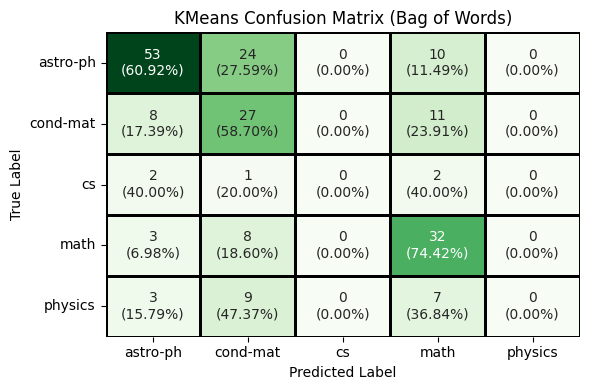

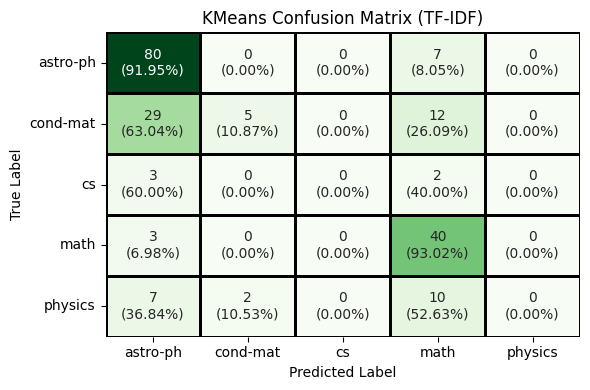

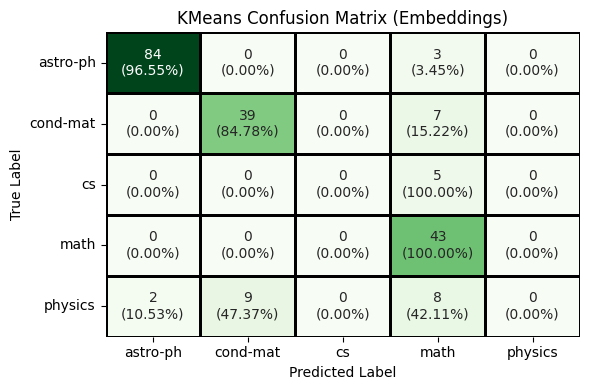

In [22]:
import os
os.makedirs("pdf/Figures", exist_ok=True)

plot_confusion_matrix(y_test, km_bow_labels, sorted_labels, "KMeans Confusion Matrix (Bag of Words)", save_path="pdf/Figures/kmeans_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_labels, "KMeans Confusion Matrix (TF-IDF)", save_path="pdf/Figures/kmeans_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_labels, "KMeans Confusion Matrix (Embeddings)", save_path="pdf/Figures/kmeans_embeddings_confusion_matrix.pdf")

# KNN Classifier

## K-Nearest Neighbors (KNN) là một thuật toán phân loại đơn giản và hiệu quả, nó phân loại một điểm dữ liệu dựa trên lớp đa số của k láng giềng gần nhất trong không gian đặc trưng.

In [23]:
def train_and_test_knn(X_train, y_train, X_test, y_test, n_neighbors: int = 5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [24]:
knn_bow_labels, knn_bow_accuracy, knn_bow_report = train_and_test_knn(X_train_bow, y_train, X_test_bow, y_test)
knn_tfidf_labels, knn_tfidf_accuracy, knn_tfidf_report = train_and_test_knn(X_train_tfidf, y_train, X_test_tfidf, y_test)
knn_embeddings_labels, knn_embeddings_accuracy, knn_embeddings_report = train_and_test_knn(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for KNN:")
print(f"Bag of Words: {knn_bow_accuracy:.4f}")
print(f"TF-IDF: {knn_tfidf_accuracy:.4f}")
print(f"Embeddings: {knn_embeddings_accuracy:.4f}")

Accuracies for KNN:
Bag of Words: 0.5200
TF-IDF: 0.8150
Embeddings: 0.8850


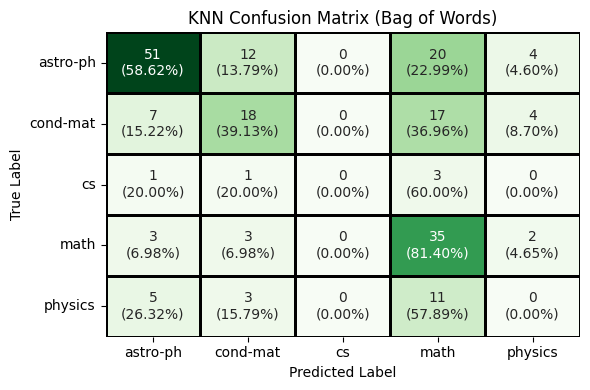

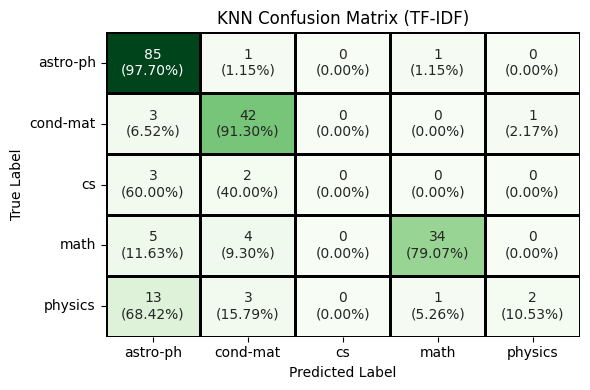

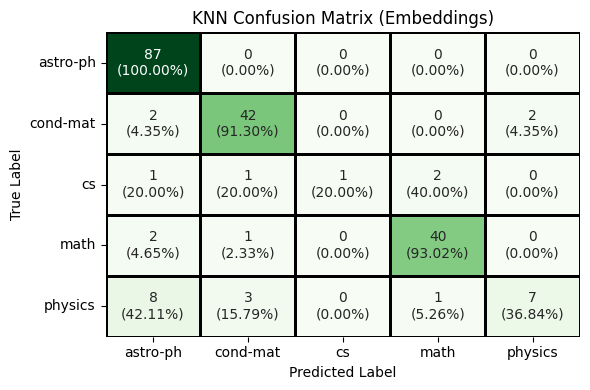

In [25]:
plot_confusion_matrix(y_test, knn_bow_labels, sorted_labels, "KNN Confusion Matrix (Bag of Words)", "pdf/Figures/knn_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_tfidf_labels, sorted_labels, "KNN Confusion Matrix (TF-IDF)", "pdf/Figures/knn_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, knn_embeddings_labels, sorted_labels, "KNN Confusion Matrix (Embeddings)", "pdf/Figures/knn_embeddings_confusion_matrix.pdf")

# Decision Tree

## Decision Tree là một thuật toán phân loại dựa trên cấu trúc cây, nó phân chia dữ liệu thành các nhánh dựa trên các đặc trưng của dữ liệu để đưa ra quyết định cuối cùng.

In [26]:
def train_and_test_decision_tree(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [27]:
dt_bow_labels, dt_bow_accuracy, dt_bow_report = train_and_test_decision_tree(X_train_bow, y_train, X_test_bow, y_test)
dt_tfidf_labels, dt_tfidf_accuracy, dt_tfidf_report = train_and_test_decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test)
dt_embeddings_labels, dt_embeddings_accuracy, dt_embeddings_report = train_and_test_decision_tree(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Decision Tree:")
print(f"Bag of Words: {dt_bow_accuracy:.4f}")
print(f"TF-IDF: {dt_tfidf_accuracy:.4f}")
print(f"Embeddings: {dt_embeddings_accuracy:.4f}")

Accuracies for Decision Tree:
Bag of Words: 0.6050
TF-IDF: 0.6450
Embeddings: 0.6500


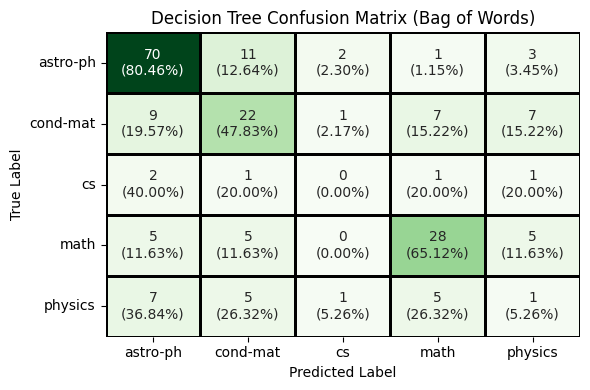

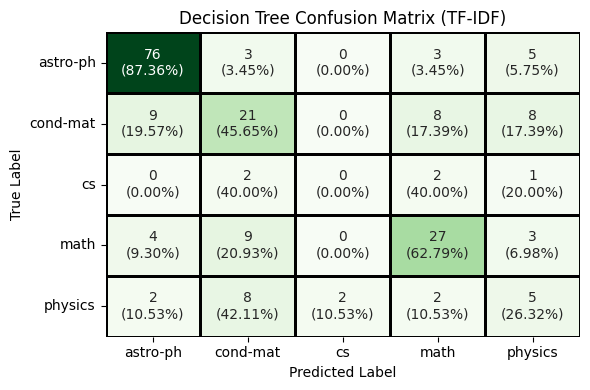

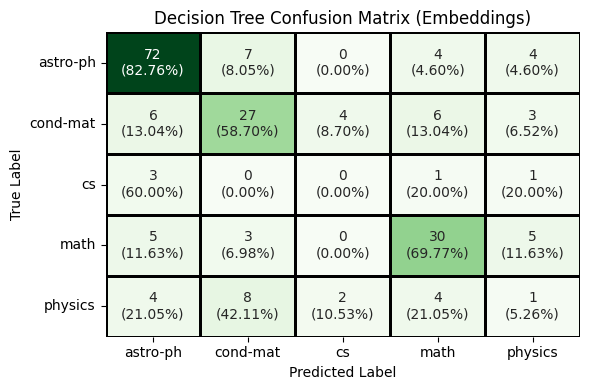

In [28]:
plot_confusion_matrix(y_test, dt_bow_labels, sorted_labels, "Decision Tree Confusion Matrix (Bag of Words)", "pdf/Figures/dt_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_tfidf_labels, sorted_labels, "Decision Tree Confusion Matrix (TF-IDF)", "pdf/Figures/dt_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, dt_embeddings_labels, sorted_labels, "Decision Tree Confusion Matrix (Embeddings)", "pdf/Figures/dt_embeddings_confusion_matrix.pdf")

# Naive Bayes

##  Naive Bayes là một thuật toán phân loại dựa trên định lý Bayes, nó giả định rằng các đặc trưng của dữ liệu là độc lập với nhau

In [30]:
from sklearn.naive_bayes import GaussianNB

def train_and_test_naive_bayes(X_train, y_train, X_test, y_test):
    nb = GaussianNB()

    # Naive Bayes requires input to be in dense format
    X_train_dense = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else X_test

    nb.fit(X_train_dense, y_train)
    y_pred = nb.predict(X_test_dense)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=sorted_labels, output_dict=True)

    return y_pred, accuracy, report

In [31]:
nb_bow_labels, nb_bow_accuracy, nb_bow_report = train_and_test_naive_bayes(X_train_bow, y_train, X_test_bow, y_test)
nb_tfidf_labels, nb_tfidf_accuracy, nb_tfidf_report = train_and_test_naive_bayes(X_train_tfidf, y_train, X_test_tfidf, y_test)
nb_embeddings_labels, nb_embeddings_accuracy, nb_embeddings_report = train_and_test_naive_bayes(X_train_embeddings, y_train, X_test_embeddings, y_test)

print("Accuracies for Naive Bayes:")
print(f"Bag of Words: {nb_bow_accuracy:.4f}")
print(f"TF-IDF: {nb_tfidf_accuracy:.4f}")
print(f"Embeddings: {nb_embeddings_accuracy:.4f}")

Accuracies for Naive Bayes:
Bag of Words: 0.8550
TF-IDF: 0.8350
Embeddings: 0.8900


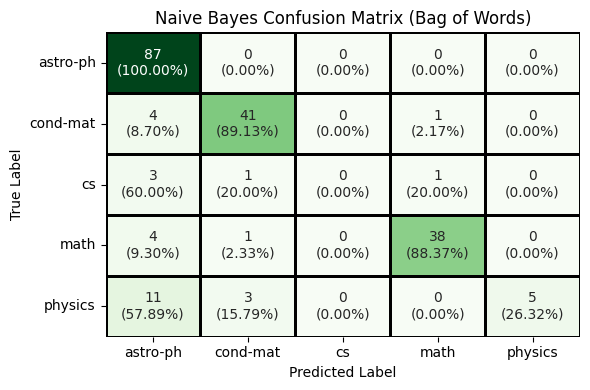

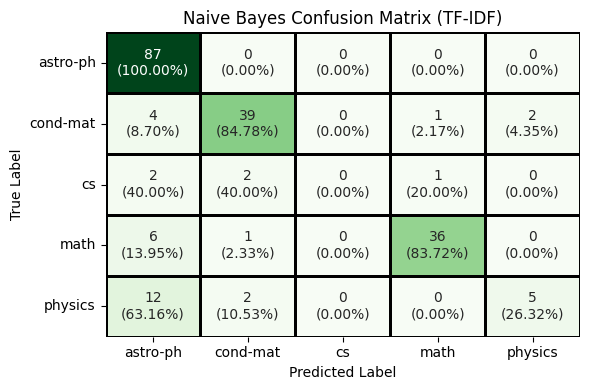

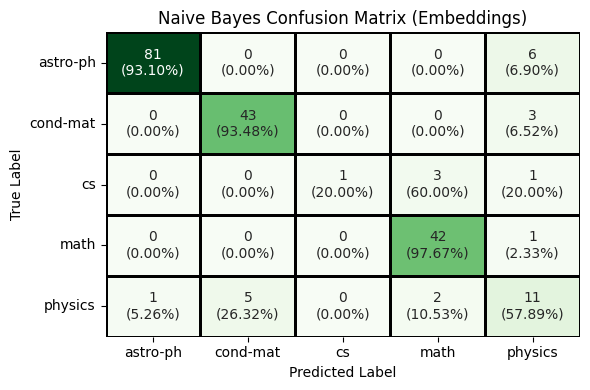

In [32]:
plot_confusion_matrix(y_test, nb_bow_labels, sorted_labels, "Naive Bayes Confusion Matrix (Bag of Words)", "pdf/Figures/nb_bow_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_tfidf_labels, sorted_labels, "Naive Bayes Confusion Matrix (TF-IDF)", "pdf/Figures/nb_tfidf_confusion_matrix.pdf")
plot_confusion_matrix(y_test, nb_embeddings_labels, sorted_labels, "Naive Bayes Confusion Matrix (Embeddings)", "pdf/Figures/nb_embeddings_confusion_matrix.pdf")